In [24]:
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io, color, transform

import cv2
import numpy as np
import os
import pandas as pd
import re

from PIL import Image
from sklearn.preprocessing import MinMaxScaler

# READ DATA

In [25]:
data = pd.read_csv("dataset.csv")

# CHECK CLASS IMBALANCE


In [26]:
class_counts = data['label'].value_counts()
print(class_counts)

label
0    2700
1    2700
2    2700
3    2700
4    2700
Name: count, dtype: int64


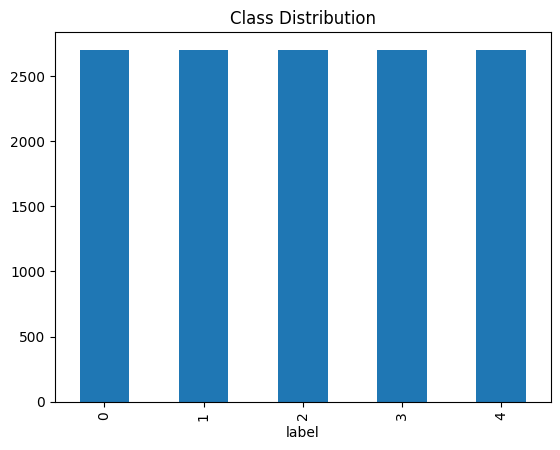

In [27]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cân bằng lớp
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()


In [28]:
total_samples = len(data)
class_ratios = class_counts / total_samples
print(class_ratios)


label
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: count, dtype: float64


# SPLIT DATA

In [29]:
x = data.drop("label", axis=1)
y = data['label']


In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

In [31]:
X_train[0]

array([0.31425257, 0.31425257, 0.29641929, 0.05224288, 0.15826826,
       0.06023148, 0.05964687, 0.05480279, 0.11045386, 0.31425257,
       0.31425257, 0.02184068, 0.01556617, 0.018835  , 0.00517374,
       0.00317036, 0.00247582, 0.10946415, 0.31425257, 0.15731166,
       0.09197295, 0.07210505, 0.19820878, 0.01357167, 0.10191999,
       0.10195651, 0.31425257, 0.19774172, 0.07698548, 0.10440363,
       0.1732285 , 0.24812958, 0.0860146 , 0.03580294, 0.02004724,
       0.03308784, 0.31740367, 0.31740367, 0.04602634, 0.03280364,
       0.03969228, 0.01090298, 0.00668111, 0.00521746, 0.23068124,
       0.06727892, 0.021512  , 0.01680114, 0.0520908 , 0.05638642,
       0.01462322, 0.0662799 , 0.02517008, 0.05827512, 0.31740367,
       0.16223673, 0.22001687, 0.31740367, 0.31740367, 0.1812644 ,
       0.07544998, 0.04224692, 0.06972825, 0.09205598, 0.02152031,
       0.08020324, 0.15279645, 0.14577436, 0.29729542, 0.31740367,
       0.14980867, 0.1638156 , 0.08692084, 0.02779238, 0.02170

# SCALE DATA

In [32]:
# Khởi tạo mô hình MinMaxScaler và fit trên tập huấn luyện
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Sử dụng mô hình đã fit để chuẩn hóa tập kiểm tra
X_test_scaled = scaler.transform(X_test)

# TRAIN

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Huấn luyện mô hình DecisionTree với các tham số cụ thể
DecisionTree_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=42, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)

DecisionTree_model.fit(X_train_scaled, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = DecisionTree_model.predict(X_test_scaled)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.3995061728395062


# EVALUATE

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Tính precision, recall, và f1-score cho từng lớp
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

class_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}\n')

for i in range(len(class_names)):
    print(f"Class {class_names[i]}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")
    print()
    
# print onverall precision, recall, f1-score for each class
print(f"Overall:")
print(f"  Precision: {precision.mean():.4f}")
print(f"  Recall: {recall.mean():.4f}")
print(f"  F1-Score: {f1.mean():.4f}")


Accuracy: 0.3995061728395062

Class Angry:
  Precision: 0.4360
  Recall: 0.2919
  F1-Score: 0.3497

Class Fear:
  Precision: 0.3319
  Recall: 0.3739
  F1-Score: 0.3516

Class Happy:
  Precision: 0.4712
  Recall: 0.5618
  F1-Score: 0.5125

Class Neutral:
  Precision: 0.4169
  Recall: 0.4805
  F1-Score: 0.4465

Class Sad:
  Precision: 0.3358
  Recall: 0.2906
  F1-Score: 0.3115

Overall:
  Precision: 0.3984
  Recall: 0.3997
  F1-Score: 0.3944


# SAVE MODEL

In [39]:
from joblib import dump
dump(DecisionTree_model, 'Model_DT.h5')

['Model_DT.h5']

# Tune

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Thiết lập các giá trị thử nghiệm cho các tham số
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Tạo mô hình Decision Tree
dt_model = DecisionTreeClassifier()

# Sử dụng GridSearchCV để tìm kiếm qua lưới tham số
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.3995061728395062
